In [7]:
import pandas as pd
import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [8]:
#Loading the data
df_data = pd.read_csv('mbti_1.csv')

# Removed |||
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_data.head()

/Users/nalisha/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:178: FutureWarning: Possible set union at position 2
  re.compile(obj)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired. That's another silly misconce...


      posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337


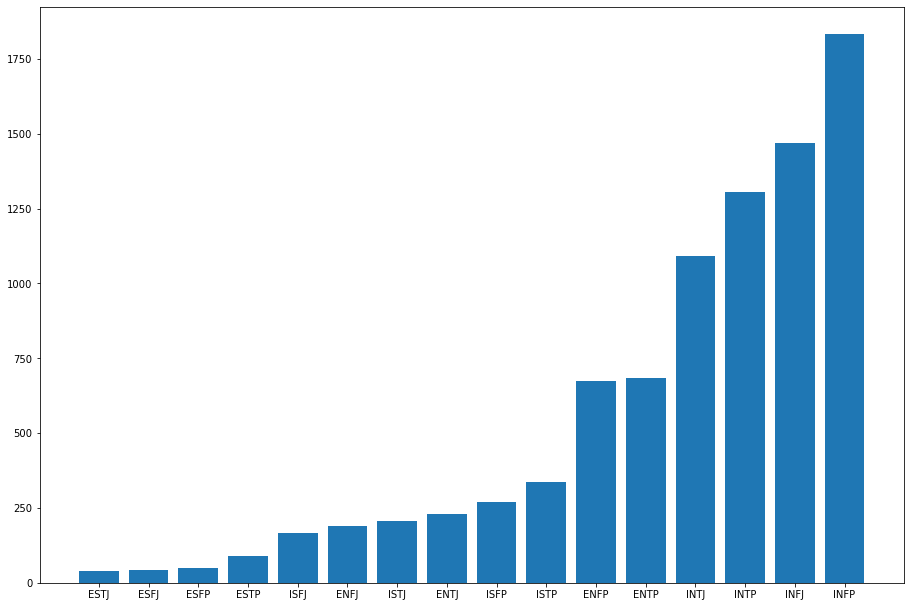

In [9]:
#Data is not balanced
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df_data[df_data.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df_data.groupby('type').count()
    if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

classes = count_class(df_data,True,True)

In [10]:
#Diving the 16 MBTI type to only 4
df_data['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_data['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_data['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_data['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_data

,type,posts,is_E,is_S,is_T,is_J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,0


In [11]:
#dropping the type column
df_data = df_data.drop(['type'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [12]:
#Separating the data according to I/E , N/S, F/T AND P/J. All of them has the post column
df_data_IE = df_data.drop(['is_S', 'is_T', 'is_J'], axis=1)
df_data_NS = df_data.drop(['is_E', 'is_T', 'is_J'], axis=1)
df_data_FT = df_data.drop(['is_S', 'is_E', 'is_J'], axis=1)
df_data_PJ = df_data.drop(['is_S', 'is_T', 'is_E'], axis=1)

df_data_IE.head()

,posts,is_E
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0
1,'I'm finding the lack of me in these posts ver...,1
2,'Good one _____ https://www.youtube.com/wat...,0
3,"'Dear INTP, I enjoyed our conversation the o...",0
4,'You're fired. That's another silly misconce...,1


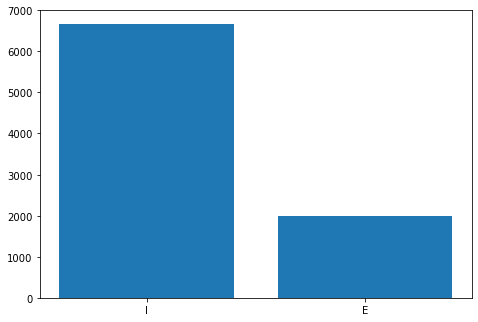

In [13]:
#After spliiting the personaliy type showing the data is still unbalanced for I/E and N/S
I, E = df_data_IE['is_E'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['I', 'E']
students = [I, E]
ax.bar(langs,students)
plt.show()

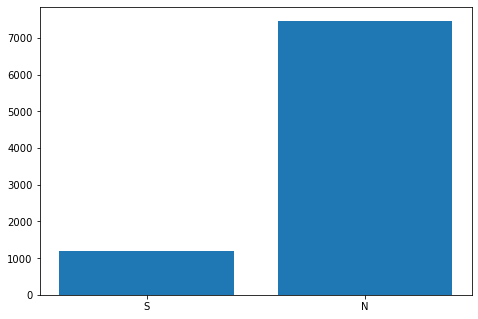

In [14]:
N, S = df_data_NS['is_S'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['S', 'N']
students = [S, N]
ax.bar(langs,students)
plt.show()

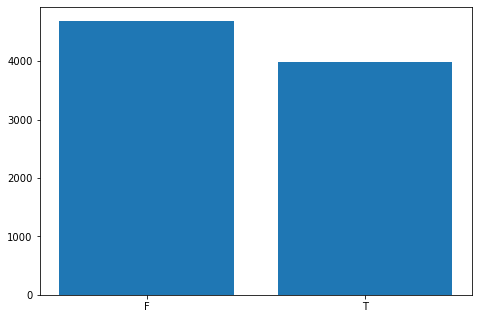

In [15]:
F, T = df_data_FT['is_T'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['F', 'T']
students = [F, T]
ax.bar(langs,students)
plt.show()

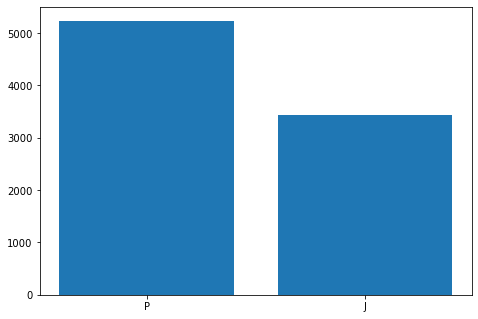

In [16]:
P, J = df_data_PJ['is_J'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['P', 'J']
students = [P, J]
ax.bar(langs,students)
plt.show()

In [17]:
# Over Sampling then undersampling
# define resampling
#over = RandomOverSampler(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
# define pipeline
#pipeline = Pipeline(steps=[('o', over), ('u', under)])

#pipeline.fit(df_data_IE)

In [18]:
#Separating into training, validation and Testing data 60, 20, 20 - 5205, 1735 and 1735
train_IE, validate_IE, test_IE = np.split(df_data_IE.sample(frac=1, random_state=42), [int(.6*len(df_data_IE)), int(.8*len(df_data_IE))])
train_NS, validate_NS, test_NS = np.split(df_data_NS.sample(frac=1, random_state=42), [int(.6*len(df_data_NS)), int(.8*len(df_data_NS))])
train_FT, validate_FT, test_FT = np.split(df_data_FT.sample(frac=1, random_state=42), [int(.6*len(df_data_FT)), int(.8*len(df_data_FT))])
train_PJ, validate_PJ, test_PJ = np.split(df_data_PJ.sample(frac=1, random_state=42), [int(.6*len(df_data_PJ)), int(.8*len(df_data_PJ))])

validate_IE   # to see the df if correct data is transfered

#Transfering to dataframe
#train_IE = pd.DataFrame(train_IE)
#validate_IE = pd.DataFrame(validate_IE)
#test_IE = pd.DataFrame(test_IE)

,posts,is_E
7201,"'Judson Joist, OMG! You deserve the highest of...",0
1812,'-Dreams are you experiencing the multiverse ...,0
5894,'Likes: 1. Extremely intelligent and well edu...,0
6510,"'Ooh, ENTJ Celestia is actually an interesting...",0
4912,Don't know much about this forum either. Lol I...,0
...,...,...
7937,"'Yay, an ISFP! Welcome! As someone with artis...",0
5016,"I just don't care anymore, I feel nothing. Per...",1
8436,"'I only know one other, my son. Is our type re...",0
987,'I don't think sense of vision is necessarily ...,0


In [19]:
#Split the data to X and Y i.e. posts and labels
#For IE labels
X_train_IE = pd.DataFrame(train_IE['posts'])
Y_train_IE = pd.DataFrame(train_IE['is_E'])
X_validate_IE = pd.DataFrame(validate_IE['posts'])
Y_validate_IE = pd.DataFrame(validate_IE['is_E'])
X_test_IE = pd.DataFrame(test_IE['posts'])
Y_test_IE = pd.DataFrame(test_IE['is_E'])

#For IE labels
X_train_NS = pd.DataFrame(train_NS['posts'])
Y_train_NS = pd.DataFrame(train_NS['is_S'])
X_validate_NS = pd.DataFrame(validate_NS['posts'])
Y_validate_NS = pd.DataFrame(validate_NS['is_S'])
X_test_NS = pd.DataFrame(test_NS['posts'])
Y_test_NS = pd.DataFrame(test_NS['is_S'])

#For IE labels
X_train_FT = pd.DataFrame(train_FT['posts'])
Y_train_FT = pd.DataFrame(train_FT['is_T'])
X_validate_FT = pd.DataFrame(validate_FT['posts'])
Y_validate_FT = pd.DataFrame(validate_FT['is_T'])
X_test_FT = pd.DataFrame(test_FT['posts'])
Y_test_FT = pd.DataFrame(test_FT['is_T'])

#For IE labels
X_train_PJ = pd.DataFrame(train_PJ['posts'])
Y_train_PJ = pd.DataFrame(train_PJ['is_J'])
X_validate_PJ = pd.DataFrame(validate_PJ['posts'])
Y_validate_PJ = pd.DataFrame(validate_PJ['is_J'])
X_test_PJ = pd.DataFrame(test_PJ['posts'])
Y_test_PJ = pd.DataFrame(test_PJ['is_J'])
#display(Y_train_IE.iloc[1])

In [20]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

X_train_IE_clean = pd.DataFrame(df_data.posts.apply(round1))
X_train_IE_clean

,posts
0,enfp and intj moments sportscenter no...
1,im finding the lack of me in these posts very ...
2,good one of course to which i say i kno...
3,dear intp i enjoyed our conversation the oth...
4,youre fired thats another silly misconceptio...
...,...
8670,ixfp just because i always think of cats as...
8671,soif this thread already exists someplace else...
8672,so many questions when i do these things i wo...
8673,i am very conflicted right now when it comes t...


In [21]:
# Tokenization - this is taken from SpaCy

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = LancasterStemmer()

def tokenize(s):
    tokens = re_tok.sub(r' \1 ', s).split()
    return tokens

In [22]:
#Remove stopword and also added the MBTI types to it
stop = set(stopwords.words('english'))
stop.update(['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [25]:
from tqdm import tqdm

embeddings_index_word2vec = {}
f = open('GoogleNews-vectors-negative300.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index_word2vec[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_word2vec))

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.txt'

In [166]:
def sent2vec(s, embeddings_index):
    words = str(s)
    words = tokenize(words)
    words = remove_stopwords(words)
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [30]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector and as the word2vec has 300 d thats why the sent vec also has 300d - ONly done for is_E for now

xtrain_IE_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_train_IE['posts']]
xvalid_IE_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_validate_IE['posts']]

xtrain_IE_word2vec = np.array(xtrain_IE_word2vec)
xvalid_IE_word2vec = np.array(xvalid_IE_word2vec)

print("xtrain_IE_word2vec.shape = ", xtrain_IE_word2vec.shape)
print("xvalid_IE_word2vec.shape = ", xvalid_IE_word2vec.shape)
 
# Generate Word vectors of test data
xtest_IE_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_test_IE['posts']]
xtest_IE_word2vec = np.array(xtest_IE_word2vec)

print("xtest_IE_word2vec.shape = ", xtest_IE_word2vec.shape)



NameError: name 'sent2vec' is not defined

In [31]:
# SVM Done for is_E class
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_word2vec, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_word2vec, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_word2vec, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E


NameError: name 'xtrain_IE_word2vec' is not defined

In [ ]:
col = ['is_E']
preds = np.zeros((valid_mes.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_word2vec, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_word2vec, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_word2vec, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

In [27]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [29]:
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_IE_word2vec, Y_train_IE[class_name], xvalid_IE_word2vec, Y_validate_IE[class_name])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_IE_word2vec), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_E


NameError: name 'xtrain_IE_word2vec' is not defined

In [ ]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector and as the word2vec has 300 d thats why the sent vec also has 300d - ONly done for is_E for now

xtrain_FT_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_train_FT['posts']]
xvalid_FT_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_validate_FT['posts']]

xtrain_FT_word2vec = np.array(xtrain_FT_word2vec)
xvalid_FT_word2vec = np.array(xvalid_FT_word2vec)

print("xtrain_FT_word2vec.shape = ", xtrain_FT_word2vec.shape)
print("xvalid_FT_word2vec.shape = ", xvalid_FT_word2vec.shape)
 
# Generate Word vectors of test data
xtest_FT_word2vec = [sent2vec(x, embeddings_index_word2vec) for x in X_test_FT['posts']]
xtest_FT_word2vec = np.array(xtest_FT_word2vec)

print("xtest_FT_word2vec.shape = ", xtest_FT_word2vec.shape)


In [ ]:
# SVM Done for is_T class
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_word2vec, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_word2vec, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_word2vec, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

In [ ]:
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)
    
    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_word2vec, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_word2vec, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_word2vec, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds
​
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
​
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
​
    return model


In [ ]:
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_FT_word2vec, Y_train_FT[class_name], xvalid_FT_word2vec, Y_validate_FT[class_name])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_FT_word2vec), ntree_limit = model.best_ntree_limit)
    gc.collect()